## Лабораторная работа №2
Выполнил: Юрков Евгений

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
test_data = pd.read_csv('data/test.csv')
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N


In [61]:
train_data = pd.read_csv('data/train.csv')
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732


In [62]:
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06
mean,1.535298e+00,1.663364e+00,-7.397347e+01,4.075093e+01,-7.397339e+01,4.075180e+01,9.617193e+02
std,4.987527e-01,1.312695e+00,6.453953e-02,3.347413e-02,6.416123e-02,3.581601e-02,5.900133e+03
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073734e+01,-7.399132e+01,4.073587e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.630000e+02
75%,2.000000e+00,2.000000e+00,-7.396734e+01,4.076834e+01,-7.396303e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Удаление выбросов по формулке из интернета.

In [63]:
# Функции для удаления выбросов

def without_outliers(series: pd.Series, coeff = 1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    return series[(series >= Q1 - coeff * IQR) & (series <= Q3 + coeff * IQR)]

def outliers(series: pd.Series, coeff = 1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    return series[(series < Q1 - coeff * IQR) | (series > Q3 + coeff * IQR)]


Ниже эта формула будет изменена.

Она слишком сильно обрезает данные, тем самым модель не обучается на некоторых значениях параметров, которые присутствуют в `test_data`.

Добавим временные признаки: час, день недели, месяц.

In [64]:
datetime = pd.to_datetime(train_data['pickup_datetime']).dt
train_data['hour'] = datetime.hour
train_data['weekday'] = datetime.dayofweek
train_data['month'] = datetime.month



train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map({'Y': True, 'N': False})

### Графики

<Axes: xlabel='hour', ylabel='count'>

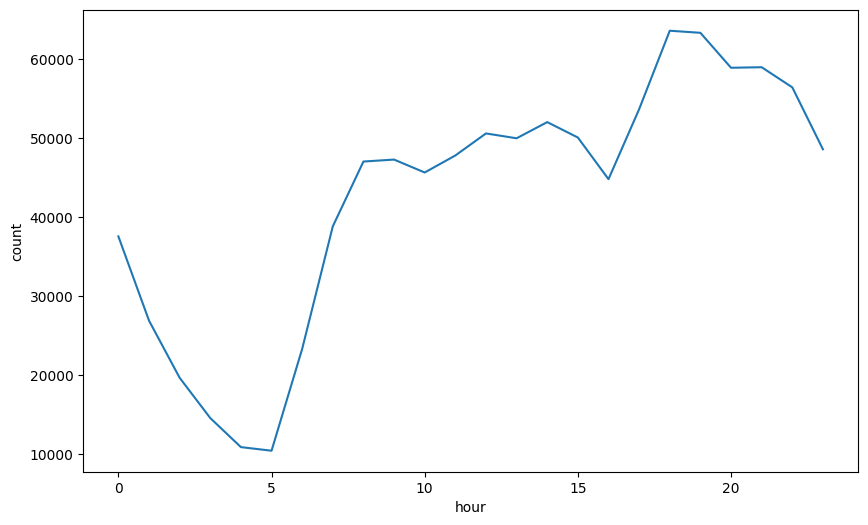

In [65]:
plt.figure(figsize=(10, 6))
sns.lineplot(train_data['hour'].value_counts())

Если прологорифмировать `trip_duration`, то получится нормальное распределение. Я попробовал сделать модель с логарифмированным таргетом, но это ухудшило её точность.

<Axes: xlabel='trip_duration', ylabel='count'>

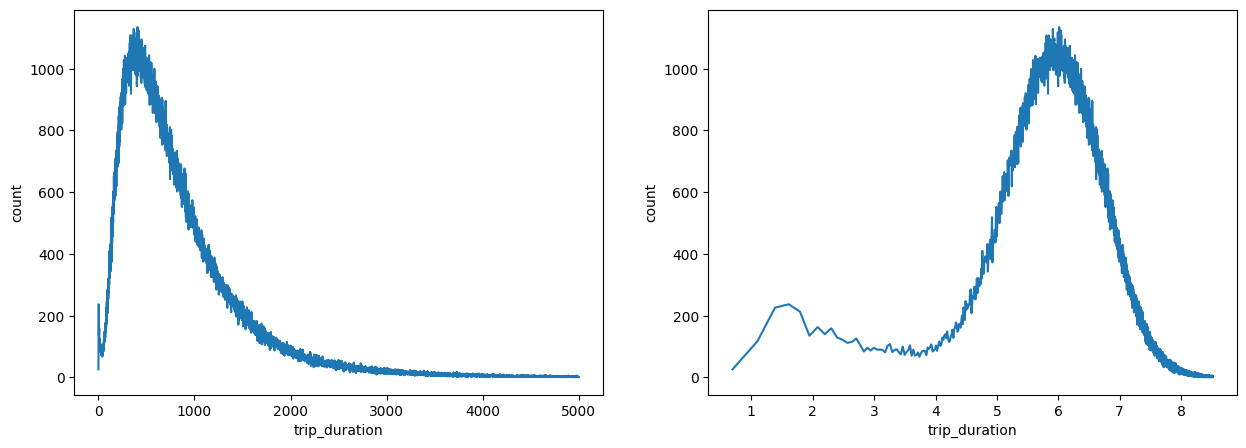

In [66]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(train_data[train_data['trip_duration'] < 5000]['trip_duration'].value_counts())
plt.subplot(1, 2, 2)
sns.lineplot(np.log(train_data[train_data['trip_duration'] < 5000]['trip_duration'] + 1).value_counts())

### Добавим длину поездки
Для расчёта расстояния будем использовать манхэттенское расстояние, так как рассматривается такси в Нью-Йорке.

In [67]:
start_pos = pd.concat([train_data['pickup_latitude'], train_data['pickup_longitude']], axis=1).to_numpy()
end_pos = pd.concat([train_data['dropoff_latitude'], train_data['dropoff_longitude']], axis=1).to_numpy()

dist = np.abs(start_pos - end_pos)
dist = dist.sum(axis=1)

train_data['distance'] = dist * 111 # перевод в километры

Нужно убрать выбросы.

<Axes: xlabel='distance', ylabel='Count'>

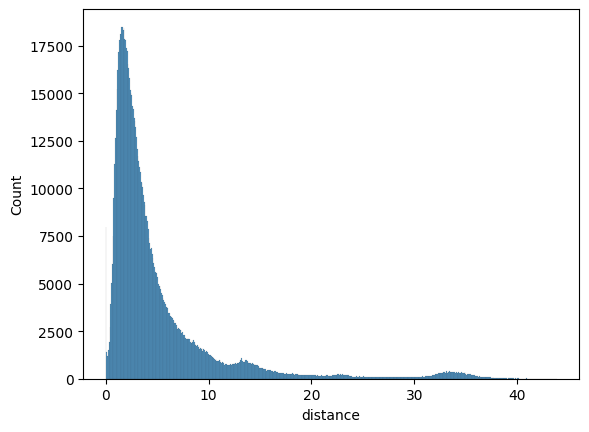

In [68]:
sns.histplot(without_outliers(train_data['distance'], 10))

Можем логарифмировать `distance` и получить нормальное распределение.

<Axes: xlabel='distance', ylabel='Count'>

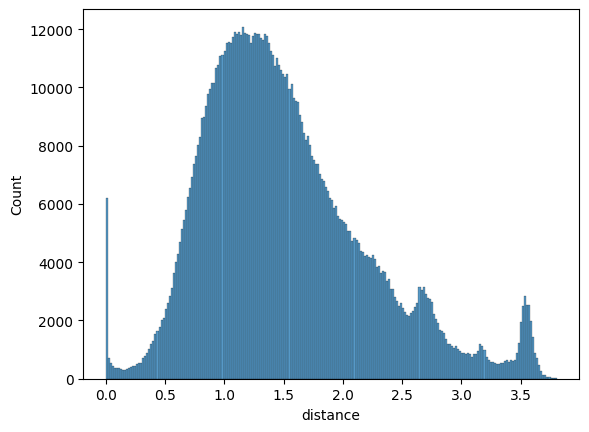

In [69]:
sns.histplot(np.log1p(without_outliers(train_data['distance'], 10)))

**Построим карту**

Добавим признак, определяющий направление поездки. Для этого построим карту точек начала и конца поездки и разобъём её на 9 частей. У нас получится два признака: `pickup_cell`, `dropoff_cell`.

In [70]:
import folium.plugins


m = folium.Map(location=[train_data['pickup_latitude'].mean(), train_data['pickup_longitude'].mean()], zoom_start=12)

heat_data = [[row['pickup_latitude'], row['pickup_longitude']] for index, row in train_data.head(1_000).iterrows()]

folium.plugins.HeatMap(heat_data).add_to(m)
m

In [71]:
# # # Создаем карту
# m = folium.Map(location=[train_data['pickup_latitude'].mean(), train_data['pickup_longitude'].mean()], zoom_start=12)

# from folium.plugins import MarkerCluster

# marker_cluster = MarkerCluster().add_to(m)

# for index, row in train_data.head(10_000).iterrows():
#     folium.Marker(
#         location=(row['pickup_latitude'], row['pickup_longitude']),
#         popup='Pickup',
#         icon=folium.Icon(color='green')
#     ).add_to(marker_cluster)

#     folium.Marker(
#         location=(row['dropoff_latitude'], row['dropoff_longitude']),
#         popup='Dropoff',
#         icon=folium.Icon(color='red')
#     ).add_to(marker_cluster)

# m


In [72]:
# lat_min = 40.55 # 40.55
# lat_max = 40.9 # 40.89
# lon_min = -74.2 # -74.2
# lon_max = -73.7 # -73.7
lat_min = min(without_outliers(train_data['pickup_latitude']).min(), without_outliers(train_data['dropoff_latitude']).min())
lat_max = max(without_outliers(train_data['pickup_latitude']).max(), without_outliers(train_data['dropoff_latitude']).max())
lon_min = min(without_outliers(train_data['pickup_longitude']).min(), without_outliers(train_data['dropoff_longitude']).min())
lon_max = max(without_outliers(train_data['pickup_longitude']).max(), without_outliers(train_data['dropoff_longitude']).max())



# Разбиваем на 3x3 частей
lat_steps = (lat_max - lat_min) / 3
lon_steps = (lon_max - lon_min) / 3

# # Добавляем прямоугольники для каждой части
# for i in range(3):
#     for j in range(3):
#         # Определяем углы прямоугольника
#         bounds = [
#             [lat_min + i * lat_steps, lon_min + j * lon_steps],  # Нижний левый угол
#             [lat_min + (i + 1) * lat_steps, lon_min + (j + 1) * lon_steps]  # Верхний правый угол
#         ]
#         # Добавляем прямоугольник на карту
#         folium.Rectangle(bounds=bounds, color='green', weight=1, fill=True, fill_opacity=0.1).add_to(m)

# m


In [73]:
# сохранение карты в файл
# m.save('data/map_split_into_9_parts.html')

Можно заметить, что плотность поездок в различных районах разная.

Если создать новые признаки, указывающие на то, в каком районе произошёл `pickup` и `dropoff`, то это должно повысить точность модели.

Попытаемся объединить два признака в один.

In [74]:
def get_cell(lat, lon):
    if not (lat_min <= lat <= lat_max) or not (lon_min <= lon <= lon_max):
        return 0  # Вне прямоугольника

    lat_idx = int((lat - lat_min) / lat_steps)
    lon_idx = int((lon - lon_min) / lon_steps)
    
    # Кодируем номер ячейки от 1 до 9
    return lat_idx * 9 + lon_idx + 1

train_data['pickup_cell'] = train_data.apply(lambda row: get_cell(row['pickup_latitude'], row['pickup_longitude']), axis=1)
train_data['dropoff_cell'] = train_data.apply(lambda row: get_cell(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
train_data['cell'] = train_data['pickup_cell'] * 10 + train_data['dropoff_cell'] # создаём уникальные пары
train_data.drop(columns=['dropoff_cell', 'pickup_cell'], inplace=True)

Объединение признаков немного повысило точность модели. Теперь направление рассматривается как один признак: откуда и куда.

In [75]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,weekday,month,distance,cell
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,False,844,9,1,5,1.556110,121
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,False,1001,16,4,1,5.754856,130
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,False,1048,13,6,4,10.918602,210
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,False,784,17,6,1,4.241936,31
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,False,732,17,3,2,3.395073,130


### Подготовка данных

**Циклическое кодирование**

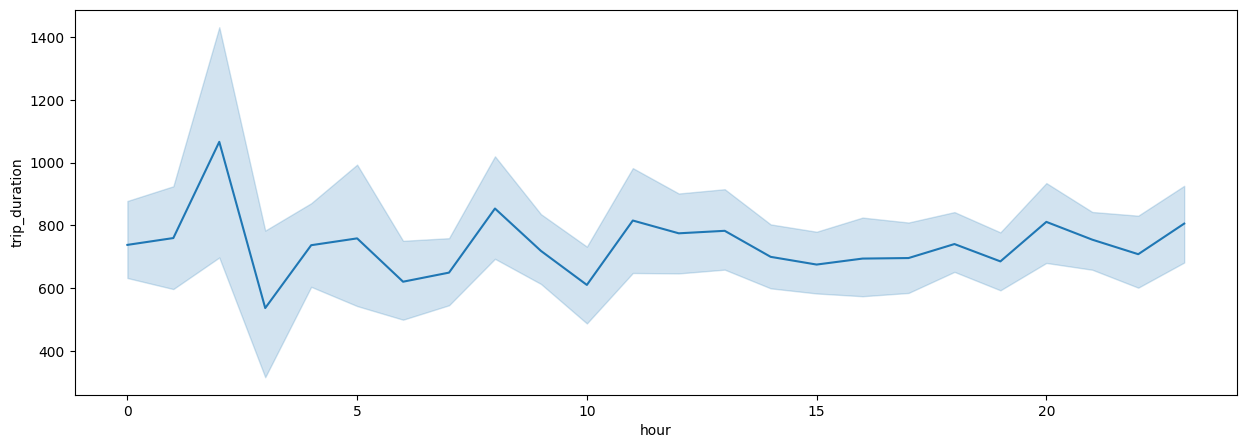

In [76]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=train_data.drop(outliers(train_data['trip_duration']).index).head(1000), x='hour', y='trip_duration');

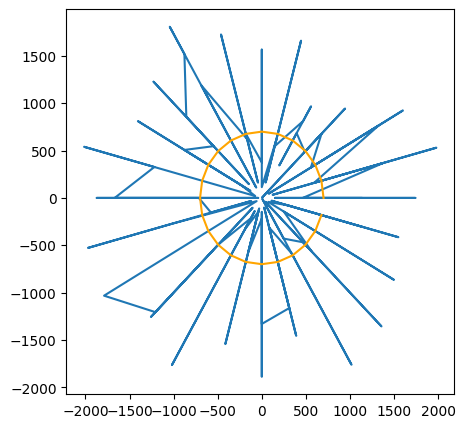

In [77]:
plt.figure(figsize=(5, 5))

hour_data = train_data.drop(outliers(train_data['trip_duration']).index).head(1000).sort_values('hour')
plt.plot((np.cos(2 * np.pi * hour_data['hour'] / 24) * hour_data['trip_duration']),
            (np.sin(2 * np.pi * hour_data['hour'] / 24) * hour_data['trip_duration']))
plt.plot((np.cos(2 * np.pi * hour_data['hour'] / 24) * 700),
            (np.sin(2 * np.pi * hour_data['hour'] / 24) * 700), color='orange')

Будем использовать циклическое кодирование для `hour`, `weekday` и `month`, чтобы учесть цикличность времени.
Оно представляет время, как точку на круге, через `sin` и `cos`.

In [78]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,weekday,month,distance,cell
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,False,844,9,1,5,1.556110,121
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,False,1001,16,4,1,5.754856,130
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,False,1048,13,6,4,10.918602,210
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,False,784,17,6,1,4.241936,31
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,False,732,17,3,2,3.395073,130


Убираем лишние признаки

In [79]:
train_data = train_data.drop(
    columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
)

In [80]:
train_data['cell'].value_counts()

cell
121    287939
111     75077
120     51169
131     49221
110     48785
21      41312
11      40258
130     38080
211     32922
221     32466
220     31714
112     29501
122     26806
31      24402
0       22555
20      21102
231     17052
22      14590
12      14574
101     12480
30       9365
230      8997
10       8532
102      7920
141      7142
210      6599
132      5965
222      5774
200      5352
100      4757
212      4551
2        4306
23       3671
1        3595
140      3576
113      3042
32       2856
41       2144
3        2040
201      1646
33       1629
40       1475
13       1403
202       912
103       908
123       292
42        246
213       122
203       114
51         37
50         27
209        16
119        12
129        12
19          5
232         2
39          1
24          1
219         1
Name: count, dtype: int64

Матрица корреляции

<Axes: >

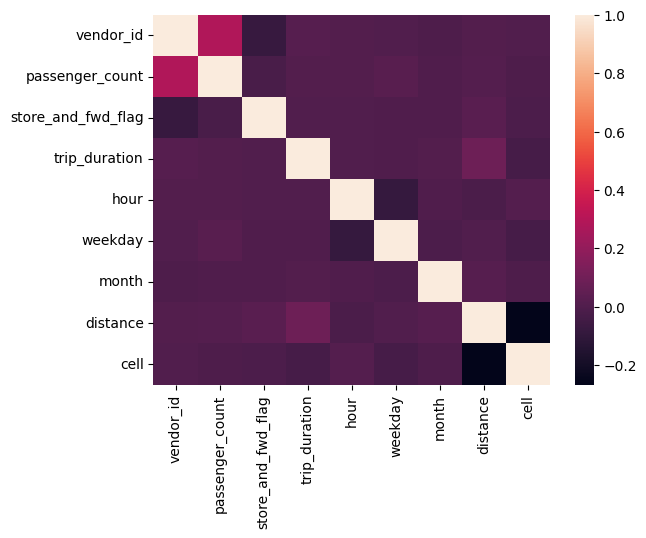

In [81]:
sns.heatmap(train_data.corr())

Используем циклическое кодирование.

In [82]:
train_data['weekday_sin'] = np.sin(2 * np.pi * train_data['weekday'] / 7)
train_data['weekday_cos'] = np.cos(2 * np.pi * train_data['weekday'] / 7)
train_data.drop(columns=['weekday'], inplace=True)

In [83]:
train_data['hour_sin'] = np.sin(2 * np.pi * train_data['hour'] / 24)
train_data['hour_cos'] = np.cos(2 * np.pi * train_data['hour'] / 24)
train_data.drop(columns=['hour'], inplace=True)

Создаем `ColumnTransformer`.

In [84]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# train_data = train_data.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime'])

num_feats = train_data.select_dtypes(np.number).columns.drop('trip_duration')
cat_feats = train_data.select_dtypes(object).columns

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['vendor_id', 'store_and_fwd_flag', 'cell', 'month']), # 'pickup_cell', 'dropoff_cell']),
    ('standard', StandardScaler(), ['distance', 'passenger_count']),
    ('cycler', 'passthrough', ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos'])
])

Убираем выбросы

Text(0.5, 1.0, 'without outliers')

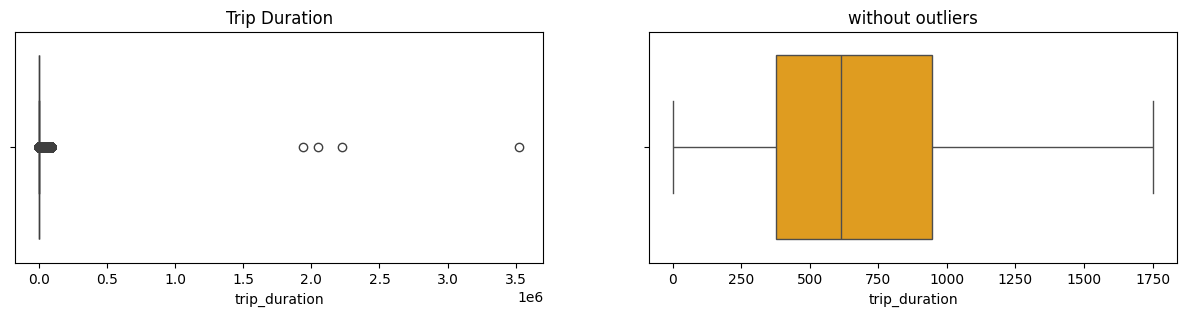

In [85]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
sns.boxplot(x='trip_duration', data=train_data)
plt.title('Trip Duration')
plt.subplot(1, 2, 2)
sns.boxplot(without_outliers(train_data['trip_duration'], 1), orient='h', color='orange')
plt.title('without outliers')

Text(0.5, 1.0, 'without outliers')

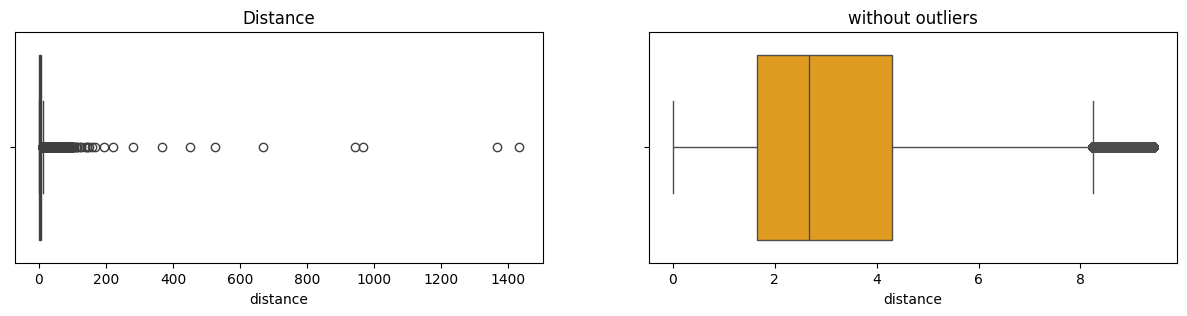

In [86]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
sns.boxplot(x='distance', data=train_data)
plt.title('Distance')
plt.subplot(1, 2, 2)
sns.boxplot(without_outliers(train_data['distance'], 1), orient='h', color='orange')
plt.title('without outliers')

In [87]:
for name in ['distance', 'trip_duration']:
    train_data.drop(outliers(train_data[name], 1).index, inplace=True)

Логарифмирование

In [88]:
train_data['distance'] = np.log1p(train_data['distance'])
# train_data['trip_duration'] = np.log1p(train_data['trip_duration'])

Остальные мучения с данными

In [89]:
y = train_data.trip_duration
X = train_data.drop(columns=['trip_duration'])

X = ct.fit_transform(X)

In [90]:
# y = np.log1p(y)

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [92]:
from sklearn.metrics import mean_squared_error as mse

def rmse(y, pred):
    return np.sqrt(mse(y, pred))

### Гиперпараметры

Подбор гиперпараметров с `GridSearchCV`.

In [93]:
from sklearn.linear_model import ElasticNet, Ridge

_model = Ridge()
paramgrid = {"alpha": np.logspace(-4, 0, num=1), "l1_ratio": np.linspace(0, 1, 1)}

In [94]:
# from sklearn.model_selection import GridSearchCV

# gridsearch = GridSearchCV(
#     estimator=model,
#     param_grid=paramgrid,
#     cv=5,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1
# )
# gridsearch.fit(X_train, y_train)

# print("Лучшие параметры: ", gridsearch.best_params_)
# print("Лучший RMSE: ", gridsearch.best_score_)

In [95]:
# # Обучаем модель с лучшими параметрами
# best_model = gridsearch.best_estimator_

# # Предсказания на тестовых данных
# y_pred = best_model.predict(X_test)

# # Вычисление RMSE на тестовых данных
# print("RMSE на тестовых данных:", rmse(y_test, y_pred))

In [96]:
_model.fit(X_train, y_train)
y_pred = _model.predict(X_test)

In [97]:
rmse(y_test, y_pred)

np.float64(222.68556922812155)

In [98]:
# rmse(np.exp(y_test) - 1, np.exp(y_pred) - 1)

In [99]:
train_data.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'month', 'distance', 'cell', 'weekday_sin', 'weekday_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

Визуализация предсказаний модели.

<Axes: xlabel='distance', ylabel='trip_duration'>

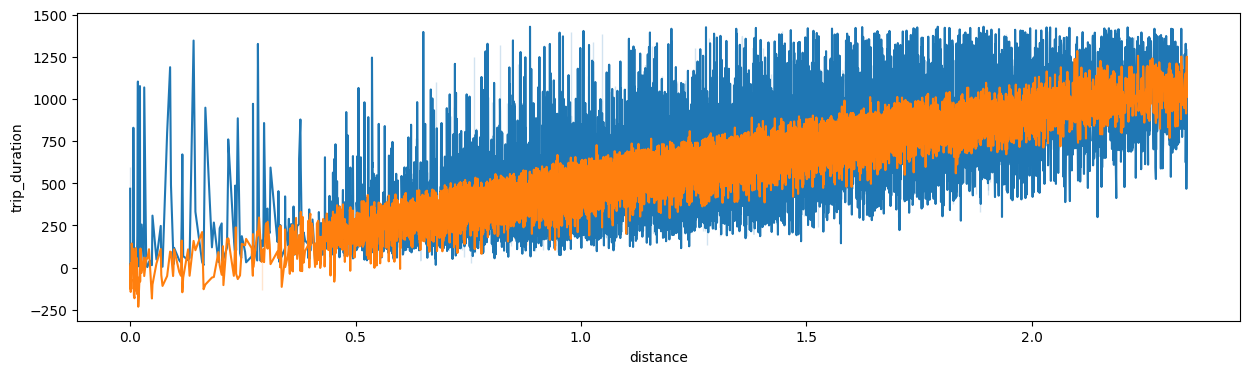

In [100]:
feature = 'distance'

plt.figure(figsize=(15, 4))
sns.lineplot(y='trip_duration', x=feature, data=train_data.head(10000))
sns.lineplot(y=_model.predict(X)[:10000], x=train_data.head(10000)[feature])

### Оценим модель через k-fold

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge, Lasso

# new_model = Lasso(alpha=0.001)
new_model = Ridge()

def log_rmse(y, pred):
    # return -rmse(np.expm1(y) + 1, np.expm1(pred) + 1)
    return -rmse(y, pred)

scorer = make_scorer(log_rmse, greater_is_better=False)
# Оцениваем модель с использованием 5-кратной кросс-валидации
scores = cross_val_score(new_model, X, y, cv=5, scoring=scorer) #scoring='neg_root_mean_squared_error')

# Среднее RMSE по всем фолдам
mean_rmse = np.abs(scores.mean())
print(f'Среднее RMSE: {mean_rmse:.4f}')

Среднее RMSE: 222.7203


**Результаты**:
- simple 4855.34
- with weekday 4855.35
- with log1p 4858.8331
- with cells 4855.1015
- with OneHotEncoding 4855.0257
- PassCount in OHE 4855.0129
- 100-Fold 3801.2191
- without outliers 273.5681
- outliers coeff=1 239.8157
- cells in 1 feat 239.6673
- with log1p(distance) 235.2999
- with weekday 233.0440
- with month 232.7832
- with special coords 229.9052
- with cycle encoding 221.8556

### Создание готовой модели

Повторяем всё описанное выше.

In [119]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

def prepare_(data):
    # время
    
    datetime = pd.to_datetime(data['pickup_datetime']).dt
    data['hour'] = datetime.hour
    data['weekday'] = datetime.dayofweek
    data['month'] = datetime.month
    # что-то там
    data['store_and_fwd_flag'] = data['store_and_fwd_flag'].map({'Y': True, 'N': False})
    # расстояние
    start_pos = pd.concat([data['pickup_latitude'], data['pickup_longitude']], axis=1).to_numpy()
    end_pos = pd.concat([data['dropoff_latitude'], data['dropoff_longitude']], axis=1).to_numpy()
    dist = np.abs(start_pos - end_pos)
    dist = dist.sum(axis=1)
    data['distance'] = dist * 111
    # направление
    lat_min = min(without_outliers(data['pickup_latitude']).min(), without_outliers(data['dropoff_latitude']).min())
    lat_max = max(without_outliers(data['pickup_latitude']).max(), without_outliers(data['dropoff_latitude']).max())
    lon_min = min(without_outliers(data['pickup_longitude']).min(), without_outliers(data['dropoff_longitude']).min())
    lon_max = max(without_outliers(data['pickup_longitude']).max(), without_outliers(data['dropoff_longitude']).max())
    lat_steps = (lat_max - lat_min) / 3
    lon_steps = (lon_max - lon_min) / 3
    def get_cell(lat, lon):
        if not (lat_min <= lat <= lat_max) or not (lon_min <= lon <= lon_max):
            return 0  # Вне прямоугольника

        lat_idx = int((lat - lat_min) / lat_steps)
        lon_idx = int((lon - lon_min) / lon_steps)
        
        # Кодируем номер ячейки от 1 до 9
        result = lat_idx * 3 + lon_idx + 1
        if result > 9:
            return 0            
        return result
    data['pickup_cell'] = data.apply(lambda row: get_cell(row['pickup_latitude'], row['pickup_longitude']), axis=1)
    data['dropoff_cell'] = data.apply(lambda row: get_cell(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    data['cell'] = data['pickup_cell'] * 10 + data['dropoff_cell'] # создаём уникальные пары
    data.drop(columns=['dropoff_cell', 'pickup_cell'], inplace=True)
    return data

def prepare_train(data):
    data = prepare_(data)
    data = data.drop(
        columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
    )
    data.drop(outliers(data['distance'], 1.5).index, inplace=True)
    return data
def prepare_test(data):
    data = prepare_(data)
    data = data.drop(
        columns=['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
    )
    return data


def drop_outliers(data: pd.DataFrame, col):
    return data.drop(outliers(data[col]).index, inplace=False)

def cycle_encoding(data: pd.DataFrame):
    encoded = pd.DataFrame()
    for col in data.columns:
        encoded[col + '_cos'] = np.cos(2 * np.pi * data[col] / (data[col].max() + 1))
        encoded[col + '_sin'] = np.sin(2 * np.pi * data[col] / (data[col].max() + 1))
    return encoded

CycleEncoder = FunctionTransformer(cycle_encoding)

colTrans = ColumnTransformer(transformers=(
    ('log', FunctionTransformer(np.log1p), ['distance']),
    ('OneHot', OneHotEncoder(handle_unknown='ignore'), ['vendor_id', 'store_and_fwd_flag', 'cell', 'month']),
    ('Standard', StandardScaler(), ['distance', 'passenger_count']),
    ('cycler', CycleEncoder, ['hour', 'weekday'])
))


Здесь изменена функция, находящая выбросы, она даёт лучший `RMSE`.

In [120]:
def without_outliers(series: pd.Series, coeff = 1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    return series[(series >= Q1 - coeff * IQR) & (series <= Q3 + coeff * IQR)]

# def outliers(series: pd.Series, coeff = 1.5):
#     Q1 = series.quantile(0.25)
#     Q3 = series.quantile(0.75)
#     IQR = Q3 - Q1

#     return series[(series < Q1 - coeff * IQR) | (series > Q3 + coeff * IQR)]

def outliers(series: pd.Series, coeff = 1.5):
    Q1 = series.quantile(0.0001)
    Q3 = series.quantile(0.9999)

    return series[(series < Q1) | (series > Q3)]

In [121]:
train_data = pd.read_csv('data/train.csv')
train_data.drop(outliers(train_data['trip_duration']).index, inplace=True)
train_data = prepare_train(train_data)

**Подбор гиперпараметров**

Очень долго считает, но чуть-чуть улучшил.

In [122]:
params = {"alpha": np.logspace(0.001, 10)}

In [123]:
from sklearn.model_selection import GridSearchCV

y = train_data['trip_duration']
X = train_data.drop(columns='trip_duration')
X = colTrans.fit_transform(X)

gs = GridSearchCV(
    estimator=Ridge(),
    param_grid=params,
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
gs.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00230524e+00, 1.60347142e+00, 2.56520719e+00, 4.10377625e+00,
       6.56515370e+00, 1.05028248e+01, 1.68022463e+01, 2.68799571e+01,
       4.30021130e+01, 6.87940726e+01, 1.10055625e+02, 1.76065178e+02,
       2.81666174e+02, 4.50604909e+02, 7.20870317e+02, 1.15323647e+03,
       1.84492872e+03, 2.95148660e+03, 4.72173...
       5.18458842e+05, 8.29421923e+05, 1.32689554e+06, 2.12274565e+06,
       3.39593355e+06, 5.43275860e+06, 8.69123780e+06, 1.39040992e+07,
       2.22435490e+07, 3.55848637e+07, 5.69280792e+07, 9.10726042e+07,
       1.45696453e+08, 2.33082788e+08, 3.72882008e+08, 5.96530499e+08,
       9.54319675e+08, 1.52670491e+09, 2.44239739e+09, 3.90730714e+09,
       6.25084566e+09, 1.00000000e+10])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [124]:
gs.best_params_

{'alpha': np.float64(110.05562510780123)}

In [125]:
Model = Pipeline(steps=(
    ('preprocessing', colTrans),
    ('model', Ridge())
))

In [126]:
Model.fit(train_data.drop(columns='trip_duration'), train_data['trip_duration'])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['distance']),
                                                 ('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vendor_id',
                                                   'store_and_fwd_flag', 'cell',
                                                   'month']),
                                                 ('Standard', StandardScaler(),
                                                  ['distance',
                                                   'passenger_count']),
                                                 ('cycler',
                                                  FunctionTransformer(func=<function cycle_encoding at 0x7f8b96dfb060>),
                                                  ['hour', 'weekday'])))),
                ('model', Ridge())])

In [127]:
test_data = pd.read_csv('data/test.csv')

In [128]:
result = pd.DataFrame({"id": test_data['id']})

In [129]:
test_data = prepare_test(test_data)

In [130]:
result['trip_duration'] = Model.predict(test_data)

In [131]:
result

,id,trip_duration
0,id2793718,968.812371
1,id3485529,985.921287
2,id1816614,576.867307
3,id1050851,981.154509
4,id0140657,3311.559058
...,...,...
437589,id2411525,736.877744
437590,id3782154,659.196548
437591,id0699942,696.895269
437592,id3422152,764.499111


In [132]:
result.to_csv('data/result.csv', index=False)

<Axes: xlabel='distance'>

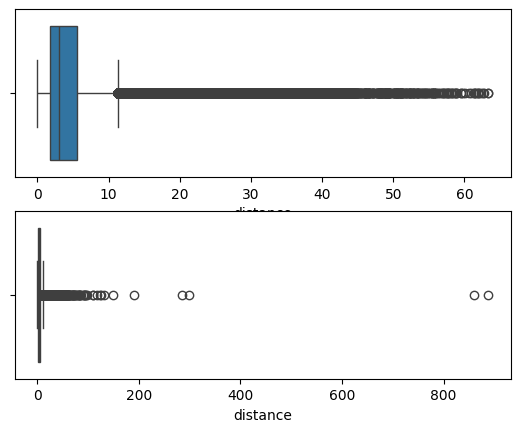

In [133]:
plt.subplot(2, 1, 1)
sns.boxplot(x='distance', data=train_data)
plt.subplot(2, 1, 2)
sns.boxplot(x='distance', data=test_data)